# Random Forest

In the previous sections, you may have noticed that we have imported classes from the `sklearn.linear_model` module. When this method is called, the regression algorithm uses a linear approximation (a line, plane or hyperplane, in higher dimensions) to fit the training data - potentially with some additional regularisation scheme.

Although quite powerful and extremely cheap in terms of computational cost, a linear approximation is necessarily limited in the type of data that it can model. Just to make a quick but relevant example, if the underlying function to be predicted is non-monotonic, any of these regression models can fail dramatically! 

Another problem of the aforementioned models (but, admittedly, not only linear models have this drawback) is that they **can only use numerical and continuous independent variables to make a prediction, which in some cases can be a rather strong limitation**. 

Let us see this with an example. Imagine we have a dataset containing information regarding the age and type of a mixed  population of human and whales, as well as the associated weigth of each member, which is the variable to be predicted. In a linear model, you would only be able to use the information regarding age, but you can easily understand that knowing whether you are talking about a human or a whale would be quite useful!

To solve some of these shortcomings, in this section we investigate the **decision tree** and its natural extension, the **random forest** algorithm, two widely used ML algorithms. As usual, we will show how they work writing down our own (streamlined) version of the algorithm to see the inner workings. Finally, we will show how we could have implemented the same algorithm in a few lines calling the pre-defined functions from `sci-kit learn`.  

Before we do that, however, let us start to load and pre-process the necessary database, looking again at our fish population as an example. 

In [4]:
#Code to import and pre-process database

import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# import the data and do the train test split
data = pd.read_csv('data tasks/400-fish-preprocessed.csv')
data = data.sample(frac=1).reset_index(drop=True)

# separate input and output column names
columns = list(data.columns)
y_col = columns.pop(0)

# split column in X, y which are the input and output variables respectively
y = data[y_col].to_numpy()
X = data[columns].to_numpy()

# Split the data into Training and Test Set
training_fraction = 0.5 # we will use 50% of the total data to train the model (this is arbitrarily chosen for now)
training_size = int(training_fraction * len(X))

X_train = X[:training_size]
X_test = X[training_size:]
y_train = y[:training_size]
y_test = y[training_size:]

## The general idea: "Prediction by proximity"

Imagine you have a function that depends on two variables $z=f(x,y)$. You probably expect that if we choose two points with similar values of $x$ and $y$, the resulting $Z$ should be similar. In fact, at least for continuous functions, we know this must be true in some limit. 

The previous principle suggests a **potential algorithm to make a prediction**:

1) Start with a set of points $\{(x_i,y_i)\}$ for which you know the corresponding value $z_i$.    
2) Given a new point $(x_p,y_p)$ for which you want to predict the corresponding $z_p$, find those points in the set $\{(x_i,y_i)\}$ which are **close** to $(x_p,y_p)$, according to some definition of **distance** or, in more general terms, a [**metric**](https://en.wikipedia.org/wiki/Metric_space) (this does not have to be necessarily your typical Euclidean distance, the **concept of distance/metric is much more general!**).  Let us call this set of **neighbours** $\{(x_n,y_n)\}$, with their corresponding $\{z_n\}$.      
3) Take $z_p$ to be the average among all $\{z_n\}$. The average can be a plain average or weighted according to the distance between points.

You should see from the list of instructions above that, in order to make a prediction, you could first partition the dataset into different regions, then find which region a new point $(x_p,y_p)$ belongs to and use the points in that region to make your final estimate. A decision tree is one simple, and extremely efficient way to do just that.

## How do we build a (random) Decision Tree

**A decision tree is a set of binary statements that you can use to define regions in the space of your independent variables**. A binary statement is a question whose answer can only have two values Yes or No. 

An excellent source with an in-depth description of Decision Trees can be found [here](https://gdcoder.com/decision-tree-regressor-explained-in-depth/), including a very useful graphical explanation. In these notes, we will try to provide the general idea by writing down the algorithm in Python (or in pseudo-code format) to see how this works in practice.

The code below explains how to build a Decision Tree for a database of purely numerical variables, but its extension to any kind of variable should not be difficult to figure out by yourself. In this description, we will call the independent variables in the problem $x_i$ (with $i \in{1,N}$), $N$ being the total number of independent variables), and we use the letter $y$ for the dependent variable we want to predict.

Because we are talking about numerical variables, our binary questions take the form "is $x_i$ greater than a certain value $B_{i,j}$?", where $B_{i,j}$ is the $j-th$ boundary for the variable $i$. Each boundary separate the reference database in two parts, and we keep only the half that our variable $x_i$ belongs to, removing the other. As we keep asking these questions, we move closer and closer to the region of points in the reference dataset that are closer to the system for which we want to predict $y$ and at some point we stop. Finally, we take the average of the remaining points as our best estimate for $y$.

Here are the steps of a potential algorithm to construct an *initial* decision tree:

1. Pick one of the $N$ input variables at random ( = choose $i$)
```python
column = random.sample(list(columns), 1)[0]
```
2. For this input variable, get the minimum and maximum values from the training data
```python
values_range = [min(X[column]), max(X[column])]
```
3. Pick a value from this range at random (i.e., decide our $B_{i,j}$)
```python
Bij = random.uniform(values_range[0], values_range[1])
```
4. Now look at the value of $x_i$ for the test data whose value you want to predict and evaluate whether its value is higher or lower than $B_j$
```python
if X_predict[column] >= Bij:
    condition = X[column] >= Bij
else:
    condition = X[column] < Bij
```
5. if it is higher, then eliminate all of the training data where their $x_i$ is lower, and vice versa if the value of $x_i$ is lower.
```python
X = X[condition == True]
y = y[condition == True]
```
6. Repeat steps 1-5 until a pre-decided **maximum depth** has been reached. In simple words, the maximum depth corresponds to the number of questions that you ask before stopping.
```python
for i in range(depth):
```
7. Take the average of the output values of the remaining training data, and this is the predicted value
```python
y_pred = y.mean()[0]
```

In practice, step 3 is equivalent to randomly deciding the boundary that divides two different regions. You then only take the points that are in the same region of your randomly chosen input variable (step 4&5). Then you partition the remaining point with another boundary and do the same. You keep partitioning the system until a certain number of partitions has been made (as defined by the depth of the tree)

> In this section we are using the following syntax: `print(f'{variable:.4f}')`. Remember that this is known as [f-string notation](https://www.python.org/dev/peps/pep-0498/), which replaces the somewhat older `.format` method of strings.

In [5]:
def decision_tree(
    _X: np.ndarray, 
    _y: np.ndarray, 
    X_predict: np.ndarray, 
    depth: int = 7,
) -> np.ndarray:
    """Use a simple decision tree algorithm to predict output data"""
    
    
    # make copies of the data in dataframe form
    X = pd.DataFrame(_X)
    y = pd.DataFrame(_y)
        
    # get column names
    columns = X.columns
    
    # iterate until depth has been reached
    for i in range(depth):
        
        print(f'>>>>\nRunning iteration #{i+1}')
        
        # pick dimension at random
        column = random.sample(list(columns), 1)[0]
        print(f'Using column [{column}]')
        
        # pick random value from range
        values_range = [min(X[column]), max(X[column])]
        print(f'Picking a value from range[{values_range[0]:.4f}, {values_range[1]:.2f})')
        
        value = random.uniform(values_range[0], values_range[1])
        print(f'Using value: {value:.4f}')
        
        if X_predict[column] >= value:
            print(f'X_predict[{column}] is {X_predict[column]:.4f} which is greater than {value:.4f}')
            condition = X[column] >= value
        
        else:
            print(f'X_predict[{column}] is {X_predict[column]:.4f} which is less than {value:.4f}')
            condition = X[column] < value
            
        # remove rows from X and y based on the condition
        X = X[condition == True]
        y = y[condition == True]
        print(f'Remaining rows: {len(X)}')
        print('<<<<\n')
    
    # Take the mean of the remaining columns
    y_pred = y.mean()[0]
    
    return y_pred

y_pred = decision_tree(X_train, y_train, X_test[0])
test_value = y_test[0]

print(f'Test Value (Normalised)     : {test_value:.4f}')
print(f'Predicted Value (Normalised): {y_pred:.4f}')

>>>>
Running iteration #1
Using column [7]
Picking a value from range[0.0000, 1.00)
Using value: 0.3565
X_predict[7] is 0.0000 which is less than 0.3565
Remaining rows: 70
<<<<

>>>>
Running iteration #2
Using column [7]
Picking a value from range[0.0000, 0.00)
Using value: 0.0000
X_predict[7] is 0.0000 which is greater than 0.0000
Remaining rows: 70
<<<<

>>>>
Running iteration #3
Using column [1]
Picking a value from range[-1.2799, 2.17)
Using value: -0.5284
X_predict[1] is -0.3001 which is greater than -0.5284
Remaining rows: 52
<<<<

>>>>
Running iteration #4
Using column [7]
Picking a value from range[0.0000, 0.00)
Using value: 0.0000
X_predict[7] is 0.0000 which is greater than 0.0000
Remaining rows: 52
<<<<

>>>>
Running iteration #5
Using column [5]
Picking a value from range[0.0000, 1.00)
Using value: 0.6671
X_predict[5] is 0.0000 which is less than 0.6671
Remaining rows: 38
<<<<

>>>>
Running iteration #6
Using column [0]
Picking a value from range[-0.5249, 2.21)
Using value:

## Optimising a tree

Although the previous algorithm might work decently in certain cases, it generates a tree that is far from optimal because the partitions of the system have been put randomly.

In an optimal tree, the various partitions $B_{ij}$ are optimised to reduce as much as possible the average variance in the predicted value of $y$. In other words, in an optimised tree the training dataset is divided in different regions in such a way that the data-points that belong to each region have a value of $y$ that is as close as possible to each other. 

One way to do this optimisation (which in sci-kit learn is done automatically, given certain so-called *hyper-parameters*) would be:

1) First, we pick randomly a subset of $M<N$ indepedent variables. $M$ is a so-called hyper-parameter of your algorithm.  
2) For each of these variables, calculate the one that gives the highest variance in $y$, considering the current partitioning. Pick that variable and go to the next step.  
3) Partition the dataset along that specific variable using different values of $B_{ij}$ (let us say, using $m$ equi-spaced values) and for each of these values, calculate the average variance of the system.  
4) Choose the value of $B_{ij}$ that provides the highest **reduction** in variance.   
5) Check your stopping criteria: if met, go back to point 1), otherwise your optimisation is finished!  

An important thing that needs to be noted about this optimisation, is the following: There is still a random component to it, step 1. Indeed, unless you have a very small number of variables, it is impossible to optimise a tree and found the best possible one, because the total number of different trees grows exponentially with the number of variables to take into account. 

## Hyperparameters of a Decision Tree

In the previous optimisation algorithm (and even earlier in the scheme that produces a random decision tree), there was something we have not really specified: When do we stop partitioning the system? In other words, **what is the stopping criteria** quoted in step 5)? This and other choices are the so-called **hyperparameters** of the model.  

Generally speaking, **hyperparameters are constant that are chosen by the user, in the sense that their value is simply provided as an input but not optimised to fit the training test**. Besides those deciding when the algorithm should stop, we have seen at least another one in the scheme described above: the number $M$ of independent variables considered for optimisation. 

Typically, the following are the hyperparameter that needs to be provided for optimisation of a decision tree, regardless of the scheme used. We provide their definition together with their name as used in sci-kit learn:

1) **The minimum number of datapoints that must be present in each final region of space / each leaf**. `min_samples_leaf : int, float, optional (default=1)` 
Note that if splitting a certain region leads to a new region with a number less than *min_samples_leaf*, the splitting is simply rejected. <br>
In sci-kit learn, `min_samples_leaf` can be either given as an integer or a float. If integer, then `min_samples_leaf` is directly the minimum number, if a float, then `min_samples_leaf` is interpreted as the fraction of the total number of data points that must remain in each region. 

2) **The minimum number of datapoints to consider a region / node for splitting**. `min_samples_split: int, float, optional (default=2)`
If integer, `min_samples_split` is directly this minimum number, if a float, `min_samples_split` again is interpreted as the fraction of the total number of samples.<br>
Note that in principle a region can contain enough data point to split it, but then the proposed splitting might generate two region with less than `min_samples_leaf`. In other words, `min_samples_leaf` and `min_samples_split` are not the same!

3) **The number of different variables $x_i$, also called "features", to consider when looking for the best split** (this is what we called $M$ in the optimisation scheme above). `max_features : int, float, string or None, optional (default=”auto”)`  
Again, if integer, then `max_features` is exactly this number. If a float, then max_features is a fraction and `int(max_features * n_features)` features are considered at each split. If `"auto”`, then `max_features=sqrt(n_features)`. If `“log2”`, then `max_features=log2(n_features)`. If `None`, then `max_features=n_features`.

4) **The maximum depth of the tree**. `max_depth : integer or None, optional (default=None)`<br>
In practice, this is the maximum number of times we repeat a splitting operation when building a tree. If you have a single independent variable, it is somewhat easy to visualise this as the number of generations / nodes in a tree or. By construction, this is also the maximum number of binary questions you will need to answer in order to use a tree for making a prediction.<br>
If `max_depth = None`, then nodes are expanded until all the terminal leaves (the regions in which we partition the dataset) are pure, in the sense that they have zero variance, or until all leaves contain less than `min_samples_split` samples. 

## Nomenclature

In reading external literature about decision trees, you might encounter a slightly different way of calling the variables describing a tree (some of which we also use here). This is a small dictionary that could help you navigate through these sources! If you think about the graph of a decision tree (see some examples [here](https://www.google.com/search?q=decision+tree+&tbm=isch&ved=2ahUKEwj8mdmF7rfwAhUMohoKHazUAt0Q2-cCegQIABAA&oq=decision+tree+&gs_lcp=CgNpbWcQAzIECCMQJzIECAAQQzIECAAQQzICCAAyBAgAEEMyAggAMgQIABBDMgIIADIECAAQQzICCABQrwZYrwZgjwhoAHAAeACAAaEBiAGhAZIBAzAuMZgBAKABAaoBC2d3cy13aXotaW1nwAEB&sclient=img&ei=OVmVYLyZIYzEaqypi-gN&bih=636&biw=1596&safe=off)), this nomenclature becomes a lot more easier and intuitive!

1) The **Root** or **Root Node**: just another name for the entire training dataset.  
2) A **Node** or **Sub-node**: a subset / partition of the training set.  
3) A **Decision node** or **branch**: A sub-node that is itself divided into another sub-node.  
2) **Splitting**: The process of dividing a node into two sub-nodes.  
3) A **Decision Node** or **branch**: A sub-node that is itself divided into another sub-node.  
4) A **Leaf** or **Terminal Node**: A sub-node that does not split anymore.  
5) A **Branch** or **Sub-Tree**: A sub section of the entire tree.  
6) **Parent** vs **Child Node**: A node, which is divided into sub-nodes is the parent of its sub-nodes, the sub-nodes are called the the child of that parent node.  

## Decision Tree in `scikit-learn`

Fortunately, `scikit-learn` contains a decision tree regression class, called `DecisionTreeRegressor`. **The good news is that `DecisionTreeRegressor` will do all the optimisation for you**, greatly streamlining the deployment of this type of regression in building real applications!

The class is used in exactly the same way that the all of the other regression techniques we have used, as can be seen below.

Score: 0.8564


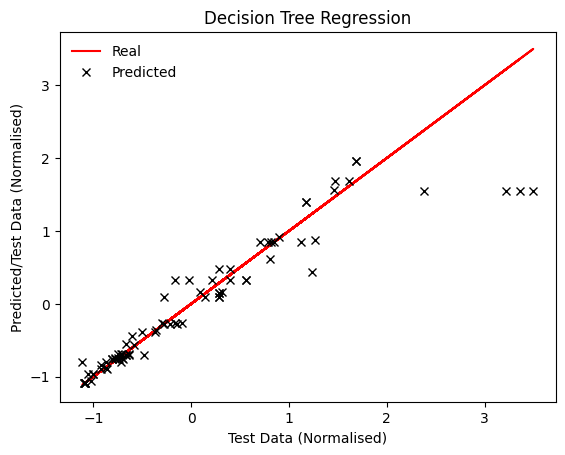

In [7]:
fig, ax = plt.subplots()
ax.plot(y_test, y_test, 'r-', label='Real')


# Use the DecisionTreeRegressor class as before to "train" the tree 
regressor = DecisionTreeRegressor().fit(X_train, y_train)
print(f'Score: {regressor.score(X_test, y_test):.4f}')

# use LinearRegression.predict to create some predicted values
y_pred = regressor.predict(X_test)
ax.plot(y_test, y_pred, 'kx', label='Predicted')


ax.set_xlabel('Test Data (Normalised)')
ax.set_ylabel('Predicted/Test Data (Normalised)')
ax.legend(frameon=False)
ax.set_title('Decision Tree Regression')
None

## From single trees to a Random Forest

One thing that you may notice is that the result of a random decision tree depends on the random state of the regressor - i.e. the value of the first split could be anywhere in the multidimensional space. Thus, the final result depends randomly on this choice and will not always be the same. This is not only true for randomly generated trees, but also for optimised ones, because there is always an element of randomness, at least in the choice of the maximum number of features $M$ to consider each time we want to try a splitting.

Another thing to consider is that a single decision tree very strongly depend on the way the dataset is partitioned. Especially for certain choices of hyper-parameters, for example, if the minimum number of sample points in each final region is too small, a single tree is prone to **over-fitting** the data. **Over-fitting** means that a model can fit perfectly your training dataset, but then perform very poorly when used to make prediction on test-sets (i.e., when we deploy for real application). 

The **random forest** algorithm is an attempt to avoid over-fitting and other issues that affect simple random trees. 

A random forest is in essence a random selection of different decision trees. Given an input set of independent variables, the **random forest algorithm runs through different decision trees and the final result is given by the mean of the predicted values**, it is no more than this. With this simple trick, various problems of decision trees (for example, over-fitting) are automatically corrected. 

On the down side, however, if a random forest uses $N$ trees, it will take $N$ times longer than a single decision tree to provide its prediction. Whether or not this extra time is compensated by a more accurate performance depends mostly on how fast you need your prediction (or how many times you have to repeat it!). In general, however, simple decision trees are seldom used in realistic ML applications, and instead random forest is almost invariably the method of choice, possibly with a small number of trees if speed is required.

The implementation in terms of code is almost exactly the same as the decision tree algorithm, and the class from `scikit-learn` is the `RandomForestRegressor`. The sample of code below illustrates how we can now achieve a score of over 90%.

Score: 0.8487


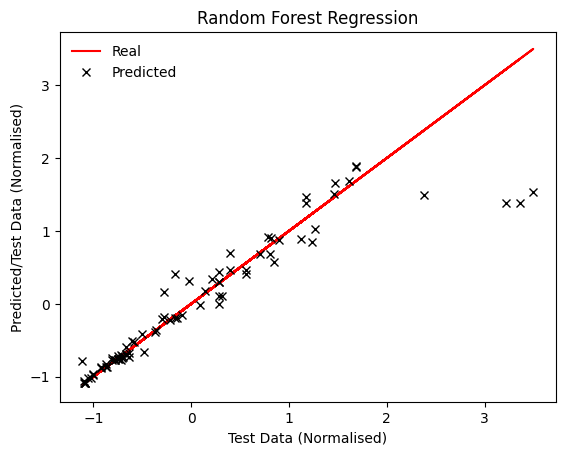

In [8]:
fig, ax = plt.subplots()
ax.plot(y_test, y_test, 'r-', label='Real')


# Use the LinearRegression class as before 
regressor = RandomForestRegressor().fit(X_train, y_train)
print(f'Score: {regressor.score(X_test, y_test):.4f}')

# use LinearRegression.predict to create some predicted values
y_pred = regressor.predict(X_test)
ax.plot(y_test, y_pred, 'kx', label='Predicted')


ax.set_xlabel('Test Data (Normalised)')
ax.set_ylabel('Predicted/Test Data (Normalised)')
ax.legend(frameon=False)
ax.set_title('Random Forest Regression')
None

# Random forests / trees for classification

We have shown here decision trees and random forests for regression, but they can be built and used in almost exactly the same way for classification. Classification, which will be introduced in the next lecture, is simply a way to predict which class a certain object belongs to. This occur when the dependent variable is a label rather than a number. Just to make a simple example, given a set of data like height, weight, age and so on, you want to predict if the object described by these variables correspond to a human, or a cat.

When used for classication, you would build your decision tree in more or less the same way. However, once we reach the leaf of a tree (a final, unsplittable region of the dataset), the label returned as prediction is the mode of the labels of all remainging points in that region, simple!

## Summary

In this section we have introduced the use of more `scikit-learn` regressors, and also introduced idea of a decision tree and collection of decision trees called a random forest.